In [1]:
!nvidia-smi

Tue May  6 17:34:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv8

YOLOv8 can be installed in two ways - from the source and via pip. This is because it is the first iteration of YOLO to have an official package.

In [3]:
# Pip install method (recommended)

!pip install ultralytics==8.2.103 -q

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.103 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.2/112.6 GB disk)


In [4]:
from ultralytics import YOLO

from IPython.display import display, Image

## Inference with Pre-trained COCO Model

`yolo mode=predict` runs YOLOv8 inference on a variety of sources, downloading models automatically from the latest YOLOv8 release, and saving results to `runs/predict`.

In [5]:
%cd {HOME}
!yolo task=detect mode=predict model=yolov8n.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True

/content
100% 6.25M/6.25M [00:00<00:00, 108MB/s]
Ultralytics YOLOv8.2.103 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 168 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs

100% 104k/104k [00:00<00:00, 95.4MB/s]
image 1/1 /content/dog.jpeg: 640x384 1 person, 1 car, 1 dog, 38.5ms
Speed: 14.6ms preprocess, 38.5ms inference, 369.7ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


/content


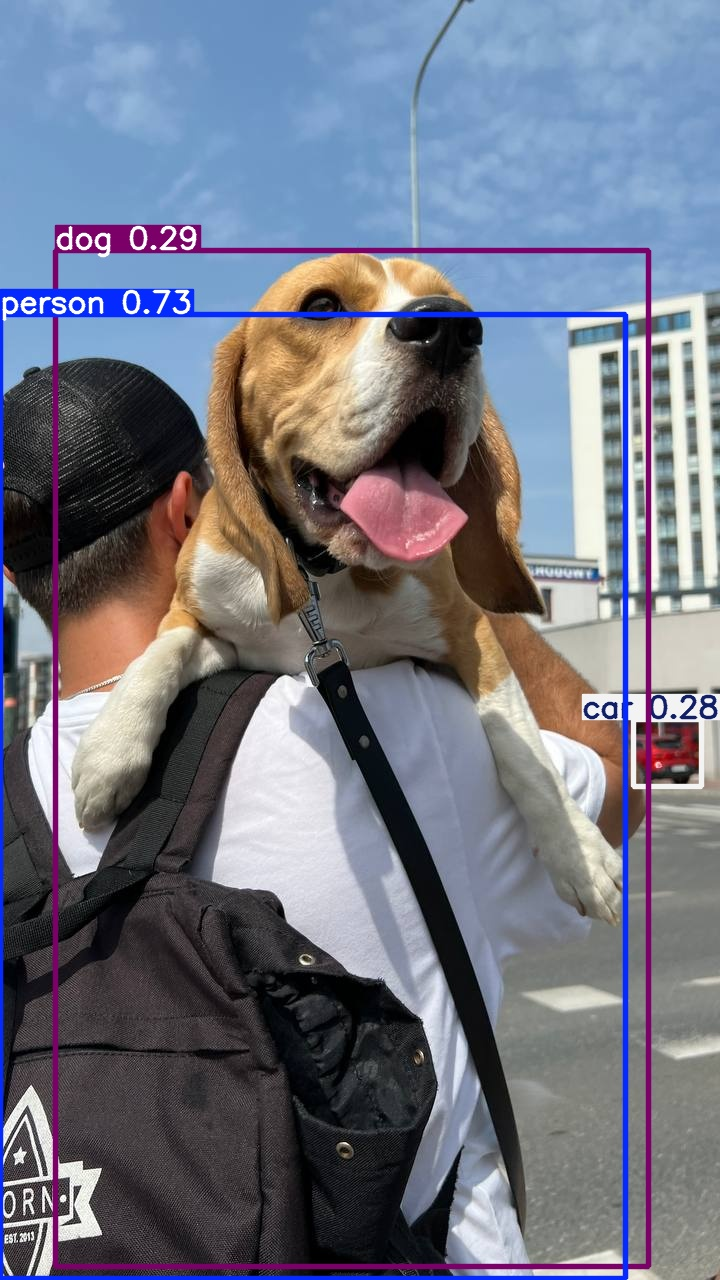

In [6]:
%cd {HOME}
Image(filename='runs/detect/predict/dog.jpeg', height=600)

In [7]:
!mkdir -p {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow==1.1.48 --quiet

from roboflow import Roboflow
rf = Roboflow(api_key="93J2JA4QhOvsFFy3ENF1")
project = rf.workspace("gachukiii").project("cocoa-disease-prediction-k3p7f")
version = project.version(4)
dataset = version.download("yolov8")


/content/datasets
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 13.9 MB/s eta 0:00:00
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Cocoa-Disease-Prediction-4 in yolov8:: 100%|██████████| 11058/11058 [00:01<00:00, 5783.45it/s]


## Custom Training

In [8]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=60 imgsz=600 plots=True

/content
100% 21.5M/21.5M [00:00<00:00, 165MB/s]
New https://pypi.org/project/ultralytics/8.3.127 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.103 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/datasets/Cocoa-Disease-Prediction-4/data.yaml, epochs=60, time=None, patience=100, batch=16, imgsz=600, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnost

Download the best model

In [9]:
from google.colab import files

files.download('/content/runs/detect/train/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Adding more training epochs

In [22]:
# !yolo detect train data={dataset.location}/data.yaml model=runs/detect/train/weights/last.pt epochs=15 plots=True

/content


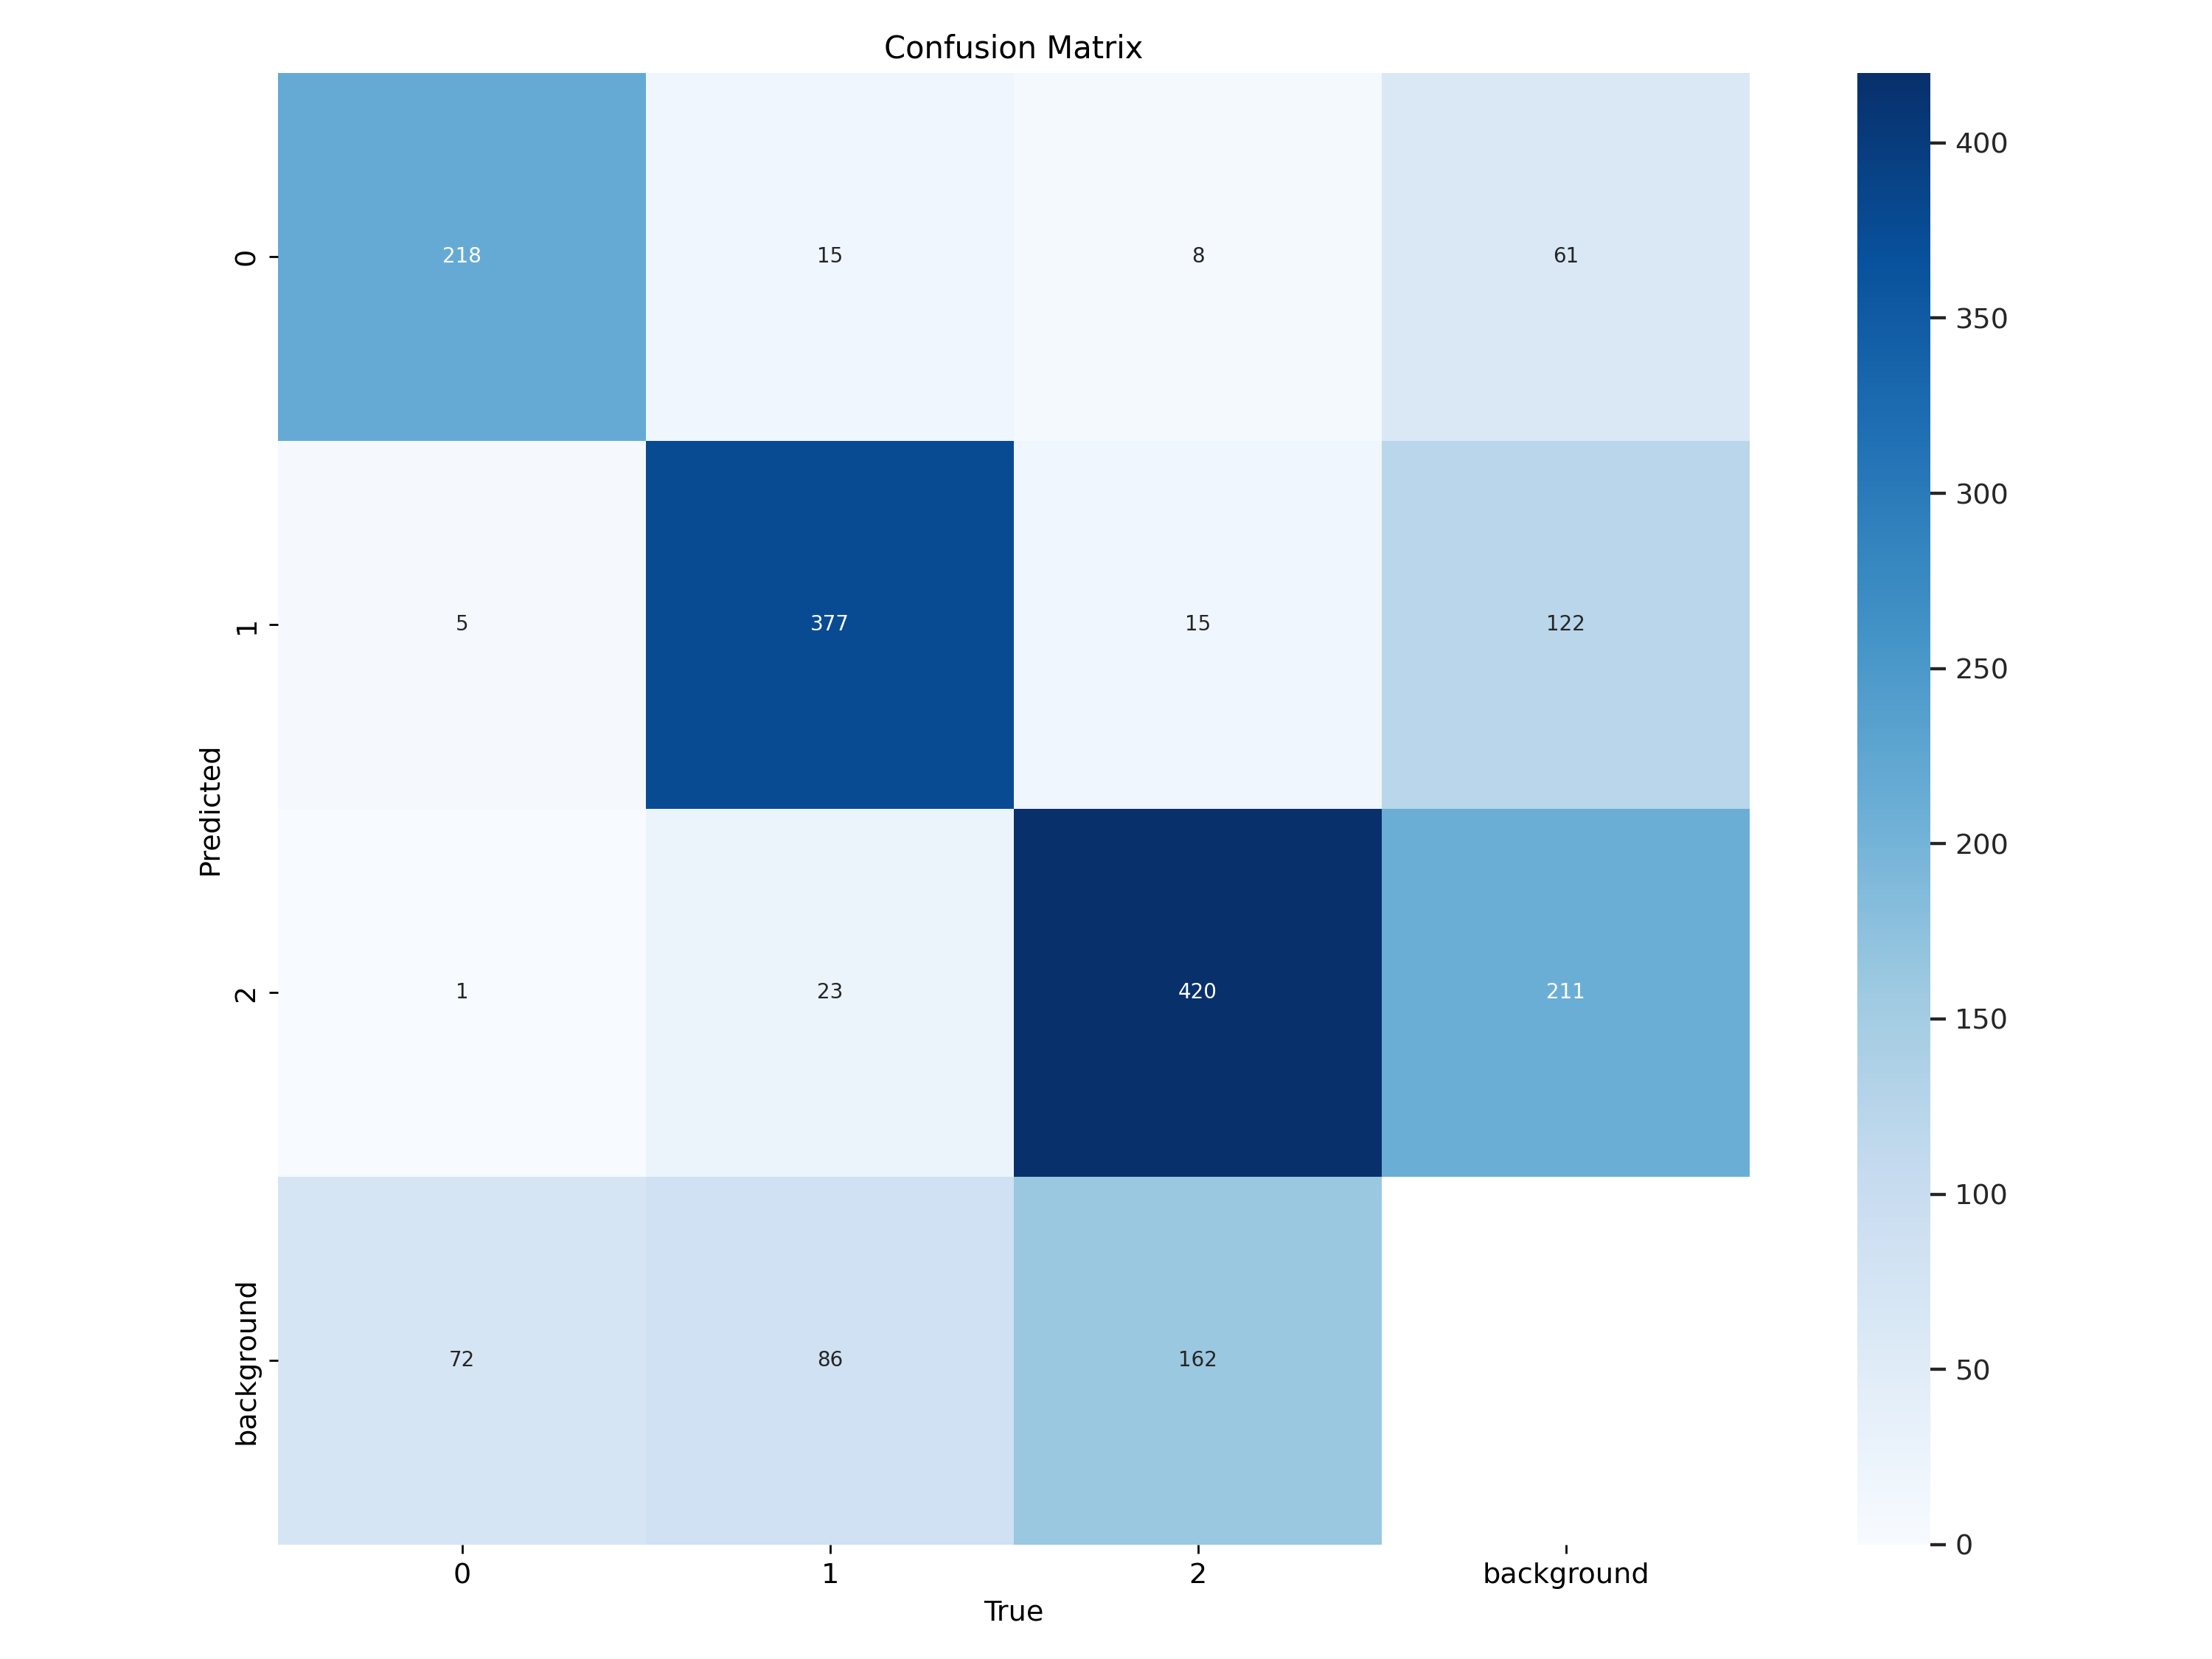

In [11]:
%cd {HOME}

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

/content


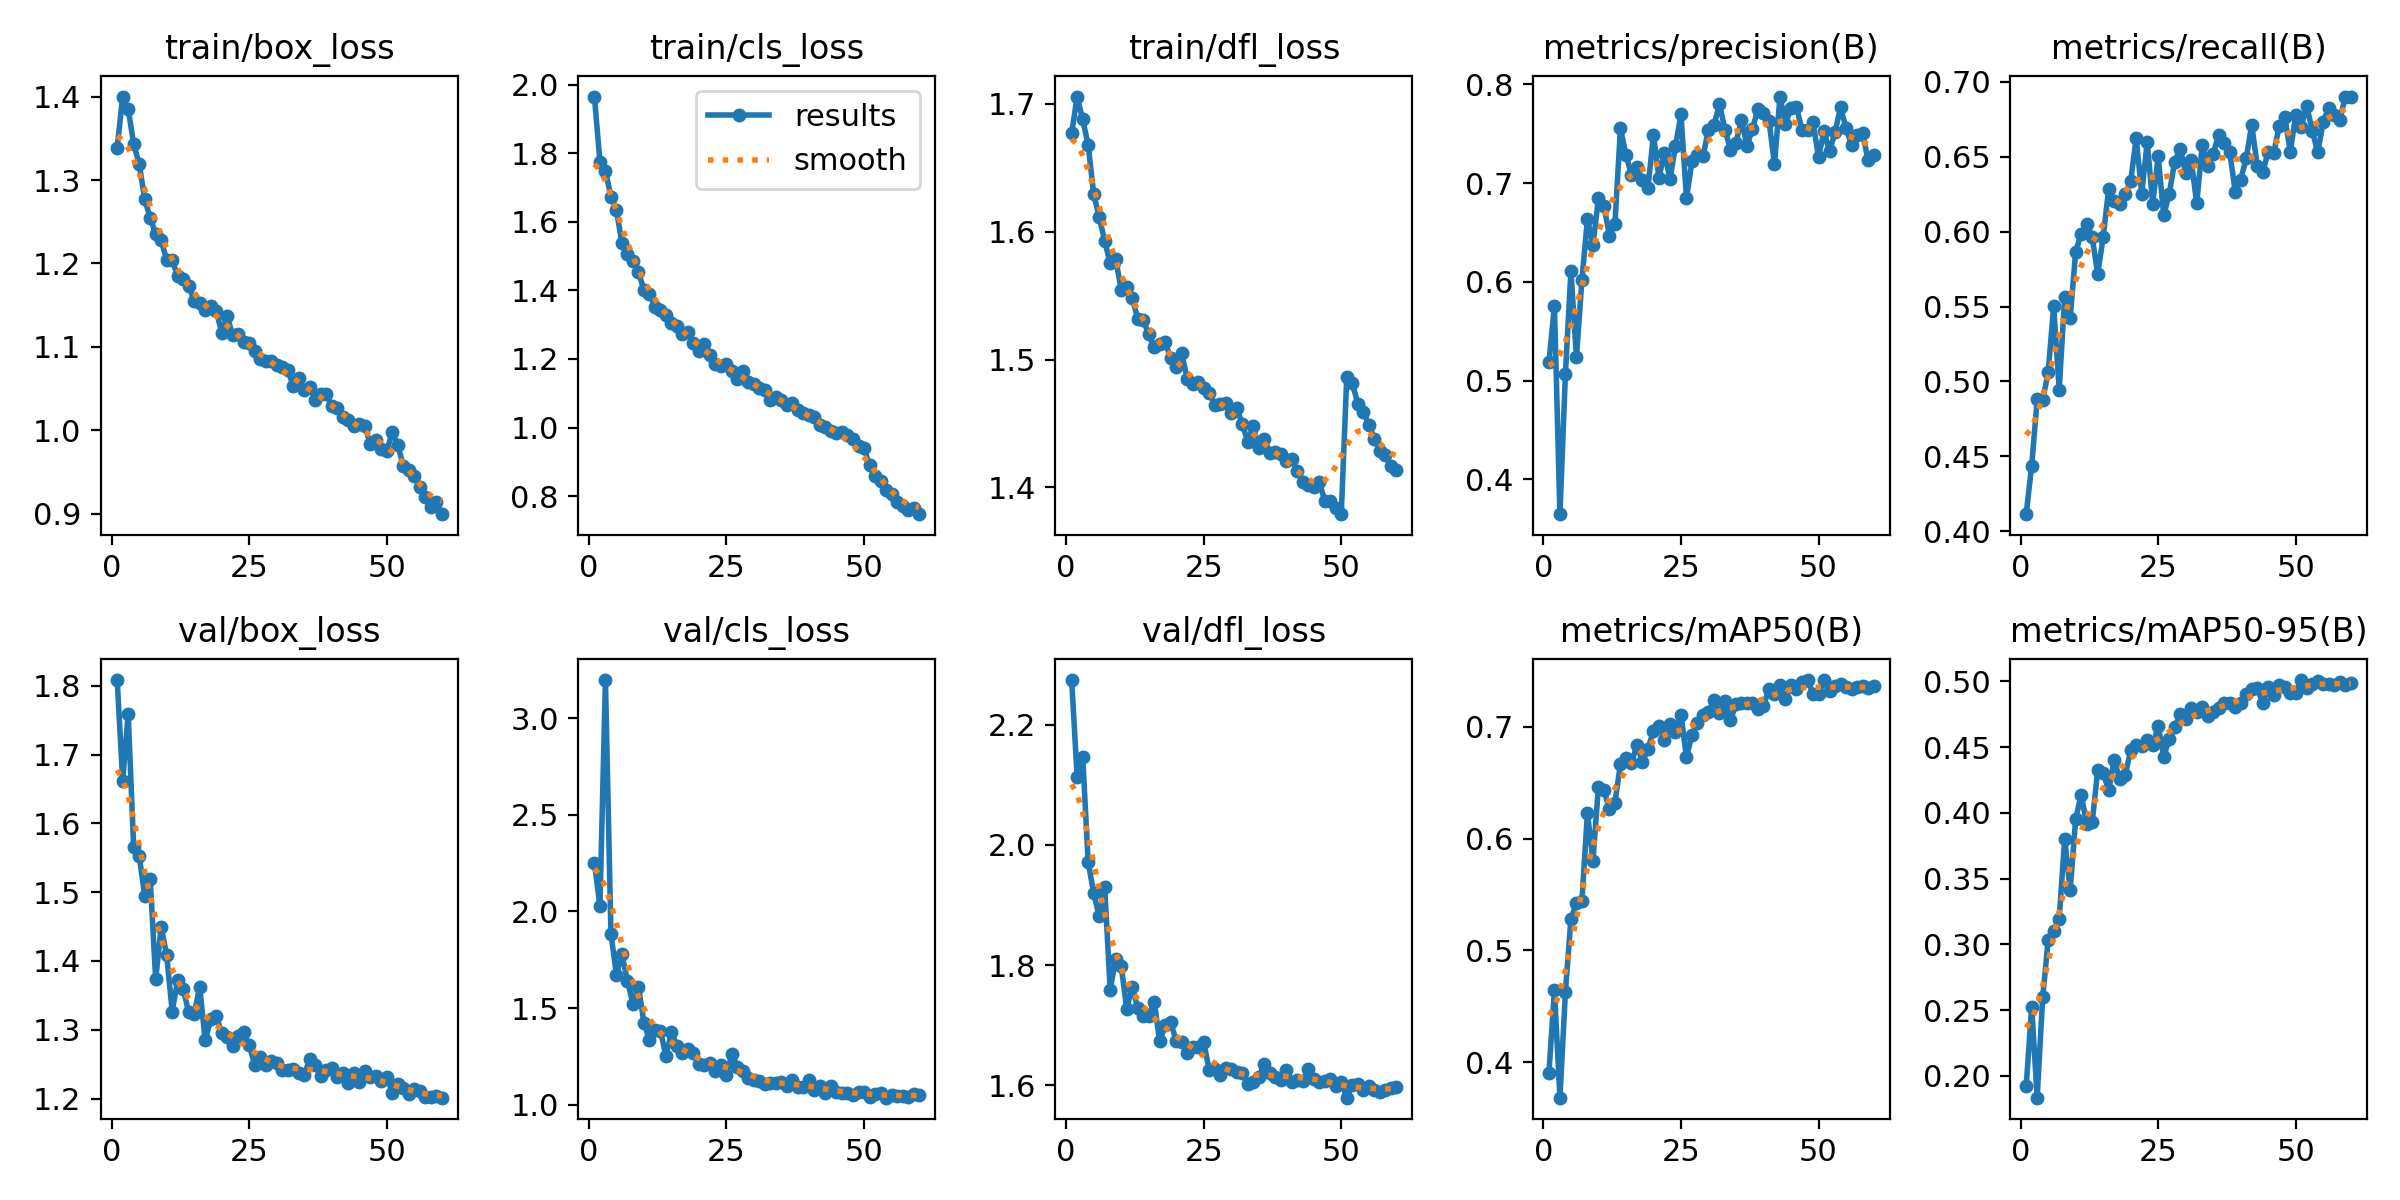

In [13]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

/content


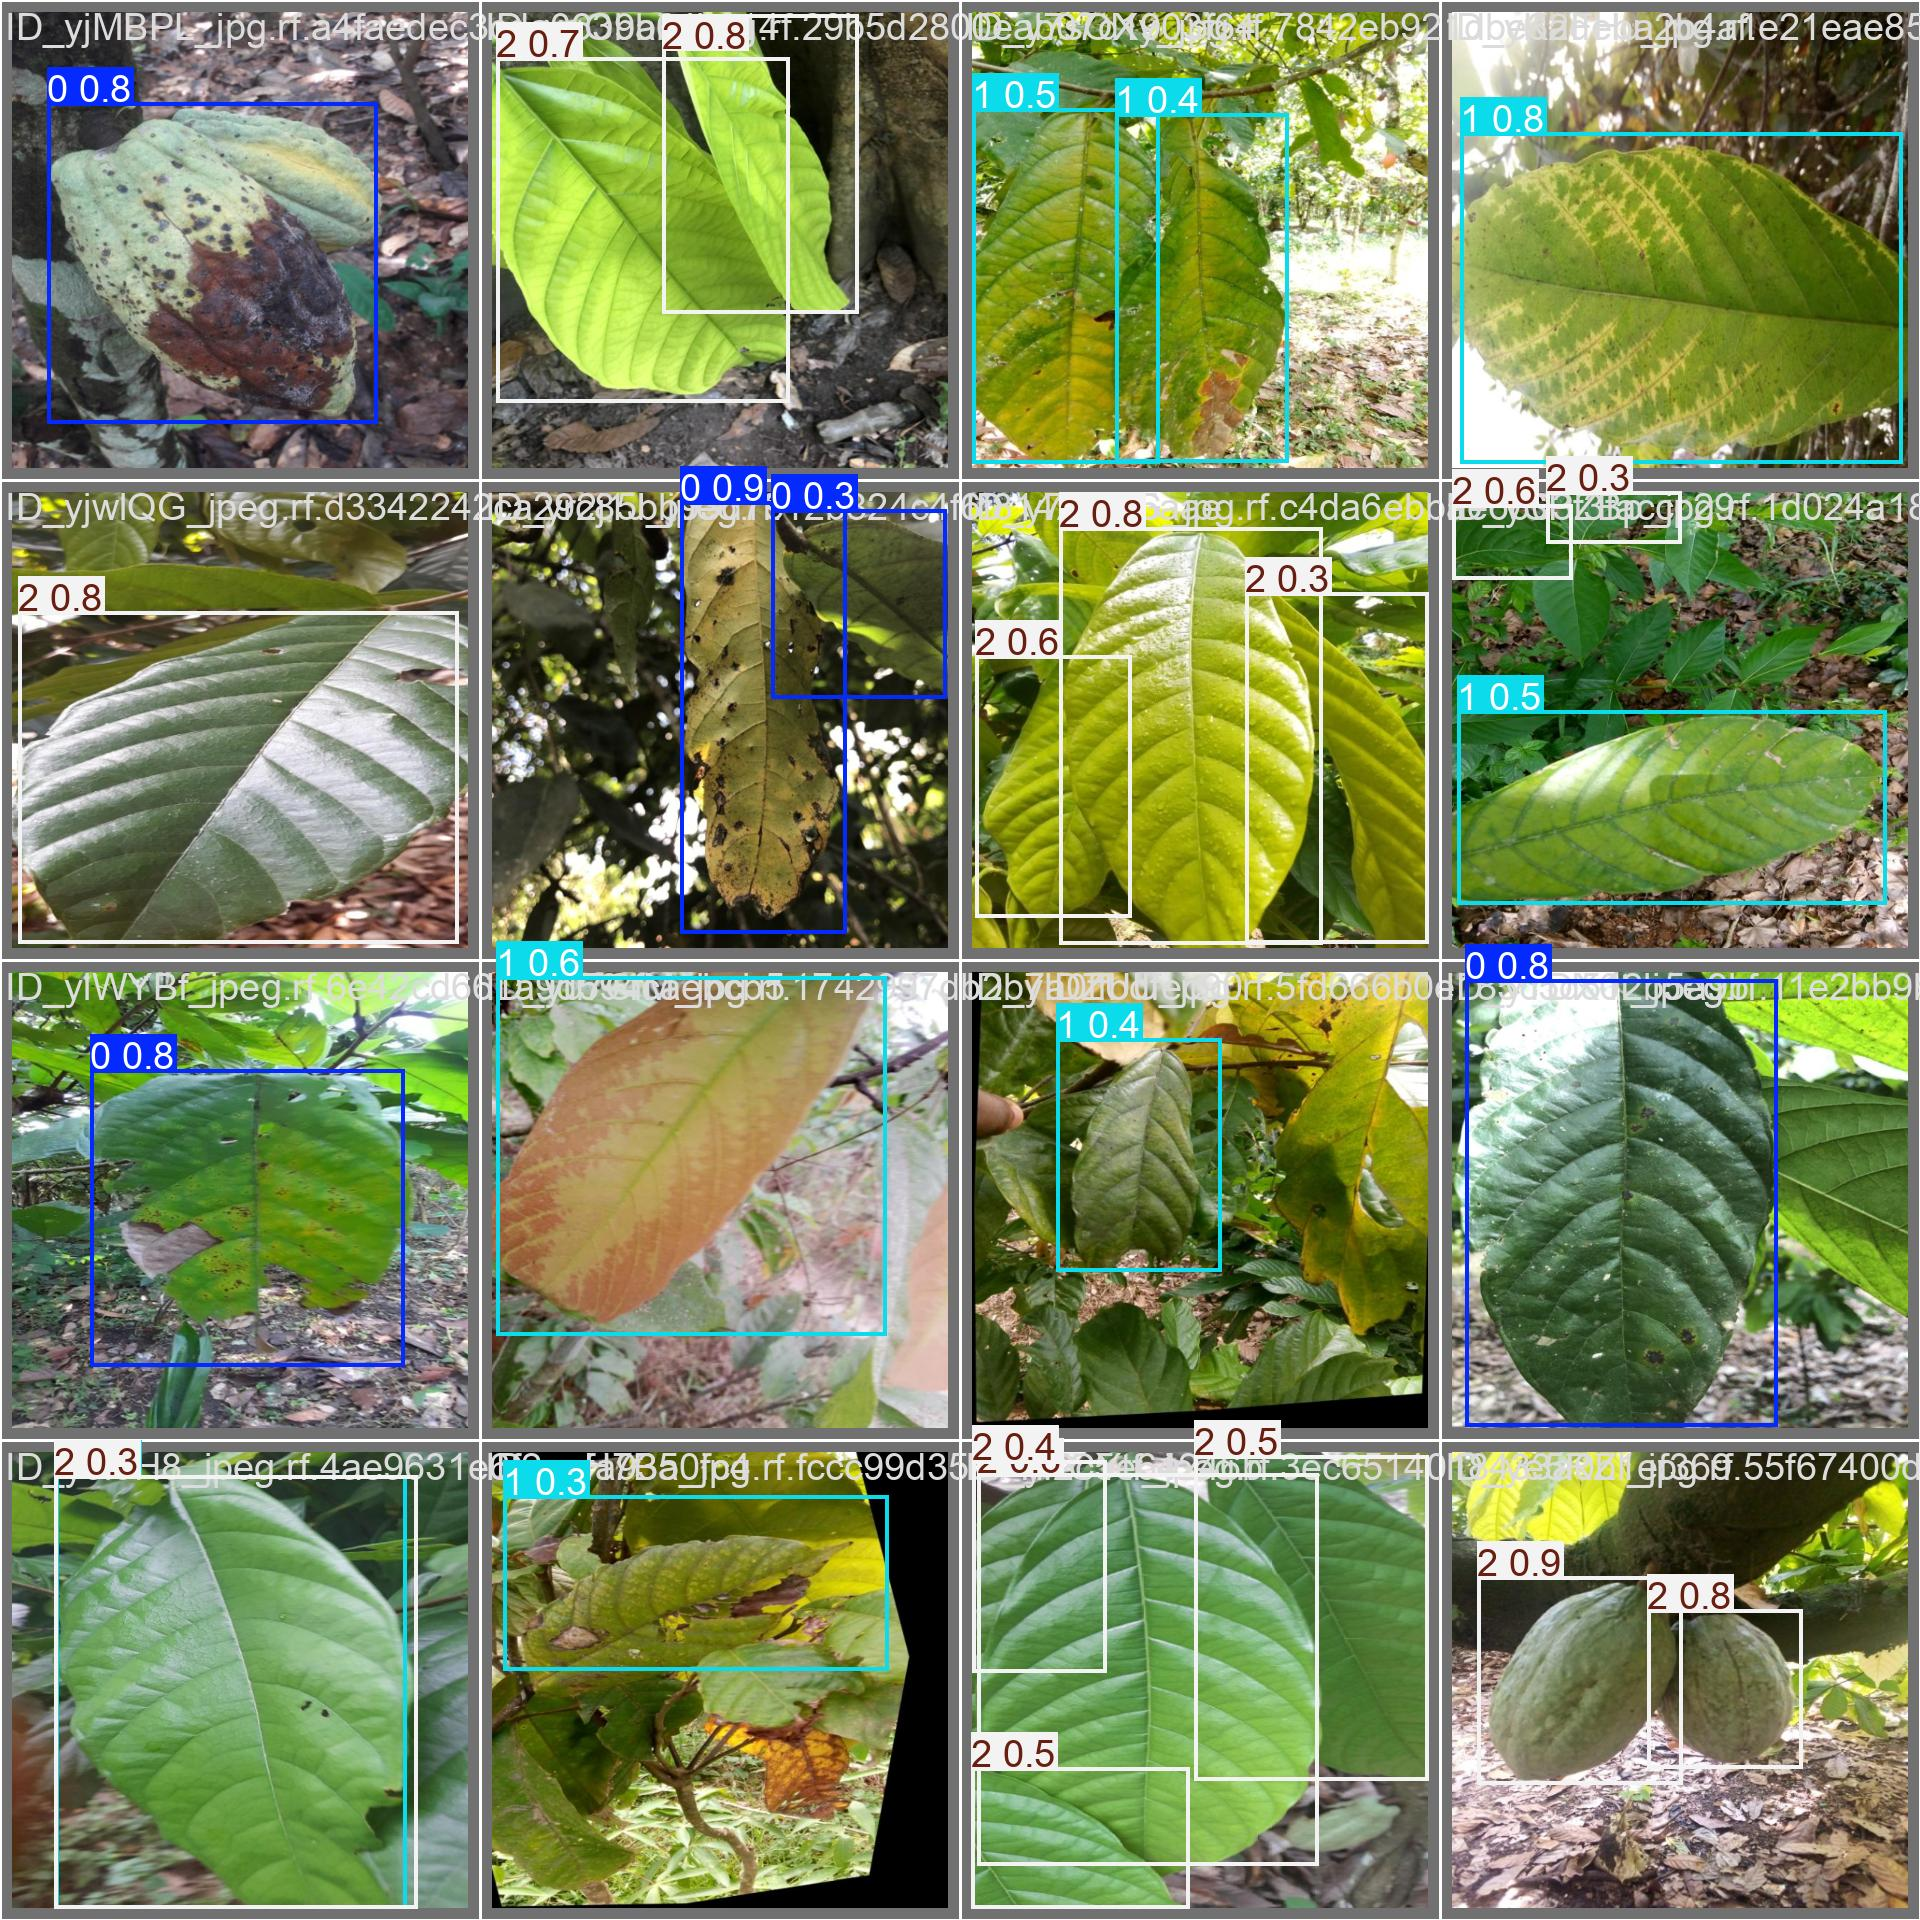

In [15]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=1000)

## Validate Custom Model

In [16]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

/content
Ultralytics YOLOv8.2.103 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/datasets/Cocoa-Disease-Prediction-4/valid/labels.cache... 812 images, 0 backgrounds, 0 corrupt: 100% 812/812 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 51/51 [00:11<00:00,  4.59it/s]
                   all        812       1402      0.753      0.669      0.741      0.501
                     0        211        296      0.755      0.682      0.756      0.515
                     1        355        501       0.79      0.691      0.761      0.534
                     2        246        605      0.713      0.635      0.707      0.455
Speed: 0.7ms preprocess, 7.4ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


## Inference with Custom Model

In [17]:
%cd {HOME}
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

/content
Ultralytics YOLOv8.2.103 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs

image 1/835 /content/datasets/Cocoa-Disease-Prediction-4/test/images/ID_A1OsZt_jpeg.rf.68f9398457b3f59ffabbec3692d4e0e6.jpg: 608x608 1 2, 15.8ms
image 2/835 /content/datasets/Cocoa-Disease-Prediction-4/test/images/ID_A397lM_jpg.rf.703d7869fee607df6c9bf50618714805.jpg: 608x608 1 1, 15.9ms
image 3/835 /content/datasets/Cocoa-Disease-Prediction-4/test/images/ID_AB0ZAJ_jpeg.rf.1ed55266bd0f43236a503580e631669d.jpg: 608x608 1 1, 15.8ms
image 4/835 /content/datasets/Cocoa-Disease-Prediction-4/test/images/ID_AC3jGA_jpeg.rf.c501277987772db497b3f257f0c5bc10.jpg: 608x608 3 2s, 15.8ms
image 5/835 /content/datasets/Cocoa-Disease-Prediction-4/test/images/ID_AGb8GD_jpg.rf.426b277c091a00474261eacdc1488b1d.jpg: 608x608 1 1, 15.8ms
image 6/835 /content/datasets/Cocoa-Disease-Prediction-4/test/images/ID_ANT5S4_jpg.rf.e9e184bcd

Download the predictions

In [18]:
import shutil
from google.colab import files

# Zip the folder
shutil.make_archive('/content/predict2_images', 'zip', '/content/runs/detect/predict2')

# Download the zip file
files.download('/content/predict2_images.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**NOTE:** Let's take a look at few results.

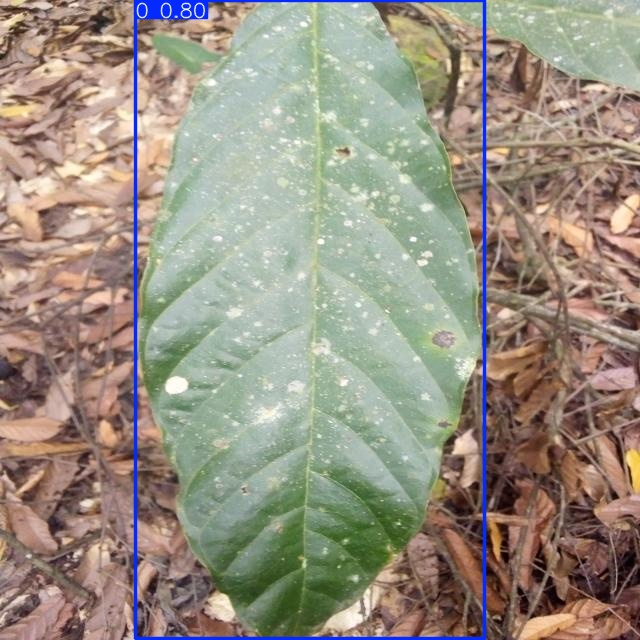

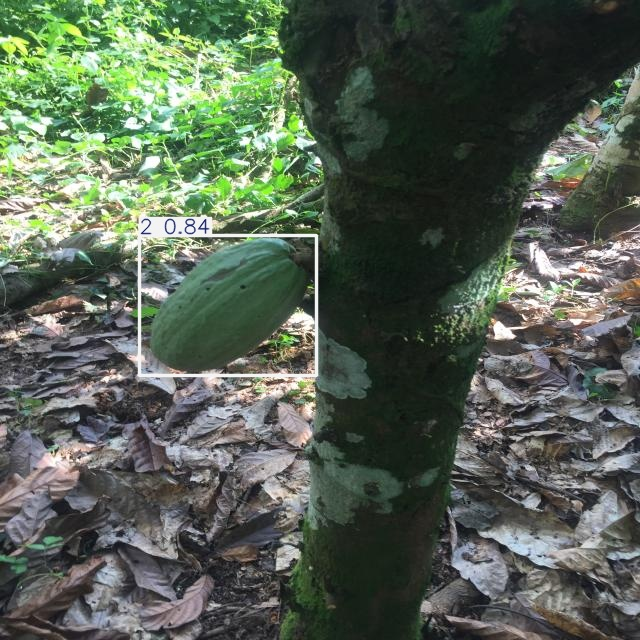

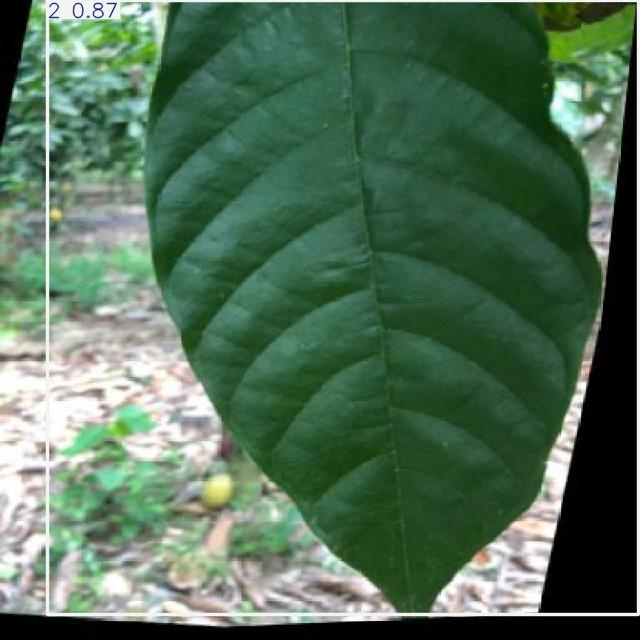

In [19]:
import glob
from IPython.display import Image, display

# Define the base path where the folders are located
base_path = '/content/runs/detect/'

# List all directories that start with 'predict' in the base path
subfolders = [os.path.join(base_path, d) for d in os.listdir(base_path)
              if os.path.isdir(os.path.join(base_path, d)) and d.startswith('predict')]

# Find the latest folder by modification time
latest_folder = max(subfolders, key=os.path.getmtime)

image_paths = glob.glob(f'{latest_folder}/*.jpg')[:3]

# Display each image
for image_path in image_paths:
    display(Image(filename=image_path, width=600))
    print("\n")